In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from river import anomaly, preprocessing, compose, ensemble, neighbors, datasets
from river.utils import numpy2dict

In [53]:
'''
EXTERNAL KERNEL
'''
google_colab = False
kaggle = False

'''
CUDA
'''
cuda = False

'''
DATA REPRESENTATION

1 => SINGLE READ | 2 => ADD FEATURES | 3 => WINDOW TO FEATURES
'''
DATA_REPRESENTATION = 1

'''
DOWNSAMPLE FACTOR

1 => 10hz *original rate* | 2 => 5Hz | 5 => 2Hz | 10 => 1hz
'''
DOWNSAMPLE_FACTOR = 5

'''
WINDOWS LENGHT

* needs divisor by datapoints target
* considering downsample factor = 5

1 => WINDOW DISABLED | 2 => 1 second | 4 => 2 seconds | 10 => 5 seconds | 20 => 10 seconds | 200 => 100 seconds *full flight*
'''
WINDOW_LENGHT =  1

'''
LIMITADOR

Quantity of samples in the execution of the tests.
'''
LIMITADOR = 20000

'''
LOSS FACTOR [0,1]

Ignores outliers in calculating the stats of losses in regenerated data.
'''
LOSS_FACTOR = 1

'''
TRAIN_SIZE [0,1]

Percentage of samples to be trained
'''
TRAIN_SIZE = 0.8

'''
OUTPUT_FILE_NAME

File with output results
'''
OUTPUT_FILE_NAME = 'output_sgdocsvm_dr_' + str(DATA_REPRESENTATION) + '-ts_' + str(TRAIN_SIZE) + '-lf_' + str.replace(str(LOSS_FACTOR), '.', '') + '-limit_' + str(LIMITADOR) + '-wl_' + str(WINDOW_LENGHT) + '.txt'

'''
PATH_OUTPUTS

'''
PATH_OUTPUTS = './outputs/'

'''
PATH_DATASET

'''
PATH_DATASET = '../../dataset/original/'

'''
FLUSH FILE

If output results file is ON
'''
FLUSH_FILE = False

In [54]:
if google_colab:
    from google.colab import drive

    drive.mount('/content/drive')
    path = '/content/drive/My Drive/ACADÊMICO/MESTRADO/DISSERTAÇÃO/CHAPTERS/5 EXPERIMENTO/dataset/data_representation_1'
    dict_ds_original = {
        'data_ds3_normal_t1_original' : pd.read_csv(path+'/F16_DS3_normal_t1.csv', header=None),
        'data_ds3_normal_t2_original' : pd.read_csv(path+'/F16_DS3_normal_t2.csv', header=None),
        'data_ds3_fault1_original' : pd.read_csv(path+'/F16_DS3_fault1_leakage.csv', header=None),
        'data_ds3_fault2_original' : pd.read_csv(path+'/F16_DS3_fault2_viscousfriction.csv', header=None),
        'data_ds3_fault3_original' : pd.read_csv(path+'/F16_DS3_fault3_compressibility.csv', header=None),
        'data_ds3_fault4_original' : pd.read_csv(path+'/F16_DS3_fault4_fixedposition.csv', header=None),
    }
elif kaggle:
    !conda install -y gdown
    !gdown --id 1G88okIVmdcgLFlmd7rDRhHvHv98yK3UB
    !gdown --id 1fX3utfHMjwKTt7IW4D01bnm-hv88yzrJ
    !gdown --id 1yUG3R5zK2AIxtS9Q4Fk-udkKBZeYShgb
    !gdown --id 1OBRDtuqNEZ-3Z-q0helWh2xGiAxeLACH
    !gdown --id 17oDi60sWYsWHHxzj2aA9m6ARm8zQ81m_
    !gdown --id 1jKEK4s5sYJh8PHtpHeV8ABOsHjuB26RA
else:
    dict_ds_original = {
        'data_ds3_normal_t1_original' : pd.read_csv(PATH_DATASET+'F16_DS3_normal_t1.csv', header=None),
        'data_ds3_normal_t2_original' : pd.read_csv(PATH_DATASET+'F16_DS3_normal_t2.csv', header=None),
        'data_ds3_fault1_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault1_leakage.csv', header=None),
        'data_ds3_fault2_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault2_viscousfriction.csv', header=None),
        'data_ds3_fault3_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault3_compressibility.csv', header=None),
        'data_ds3_fault4_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault4_fixedposition.csv', header=None),
    }

In [55]:
dict_ds = dict_ds_original.copy()

if dict_ds['data_ds3_normal_t1_original'].shape[0] % DOWNSAMPLE_FACTOR != 0 or dict_ds['data_ds3_fault1_original'].shape[0] % DOWNSAMPLE_FACTOR != 0:
    raise Exception('Needs to be ?shape? divisor')

for n, dataset_name in enumerate(dict_ds):
    dataset = dict_ds[dataset_name].to_numpy()

    downsampled = dataset[::DOWNSAMPLE_FACTOR]

    x, y = downsampled.shape

    # resample
    dict_ds[dataset_name] = pd.DataFrame(downsampled.reshape((int(x/WINDOW_LENGHT),y*WINDOW_LENGHT)))


In [56]:
# ADD COLUMNS WITH DIFF PREVIOUS VALUES

if (DATA_REPRESENTATION == 2):
    frame_size = int(1000/DOWNSAMPLE_FACTOR)

    for n, dataset_name in enumerate(dict_ds):
        dataset = dict_ds[dataset_name].to_numpy()

        dimension = dataset.shape[1]
        samples = dataset.shape[0]

        # GENERATE NEW DIMENSIONS
        dataset = np.concatenate((dataset, np.zeros((samples,dimension))), axis=1)

        for f in np.arange(0,int(samples/frame_size)):
            # OBTAIN THE FRAME FLIGHT
            frame = dataset[f*frame_size:(f+1)*frame_size, 0:dimension]

            # CALCULATE DIFFERENCE
            chunk = np.diff(frame, axis=0)

            # DONT CALCULATE THE DIFFERENCE FOR EACH FIRST TIMESTEP
            chunk = np.insert(chunk, 0, frame[0, 0:dimension], axis=0)

            # UPDATE DATASET WITH NEW FRAME INTO NEW DIMENSIONS
            dataset[f*frame_size:(f+1)*frame_size,dimension:dimension*2] = chunk

        dict_ds[dataset_name] = pd.DataFrame(dataset)



In [57]:
ss = StandardScaler()

data_ds3_t1_normal = dict_ds['data_ds3_normal_t1_original']
data_ds3_t2_normal = dict_ds['data_ds3_normal_t2_original']
data_ds3_fault1 = dict_ds['data_ds3_fault1_original']
data_ds3_fault2 = dict_ds['data_ds3_fault2_original']
data_ds3_fault3 = dict_ds['data_ds3_fault3_original']
data_ds3_fault4 = dict_ds['data_ds3_fault4_original']

# fit values
ss.partial_fit(data_ds3_t1_normal)
ss.partial_fit(data_ds3_t2_normal)
ss.partial_fit(data_ds3_fault1)
ss.partial_fit(data_ds3_fault2)
ss.partial_fit(data_ds3_fault3)
ss.partial_fit(data_ds3_fault4)

# transform values
data_ds3_t1_normal = ss.transform(data_ds3_t1_normal)
data_ds3_t2_normal = ss.transform(data_ds3_t2_normal)
data_ds3_fault1 = ss.transform(data_ds3_fault1)
data_ds3_fault2 = ss.transform(data_ds3_fault2)
data_ds3_fault3 = ss.transform(data_ds3_fault3)
data_ds3_fault4 = ss.transform(data_ds3_fault4)

# append normal labels
data_ds3_t1_normal = np.append(data_ds3_t1_normal, np.zeros((data_ds3_t1_normal.shape[0],1)), axis = 1)
data_ds3_t2_normal = np.append(data_ds3_t2_normal, np.zeros((data_ds3_t2_normal.shape[0],1)), axis = 1)

# append fault labels
def generate_fault_label(dataset, fault_label):
    labels = np.array([[fault_label]]*dataset.shape[0])

    return labels

data_ds3_fault1 = np.append(data_ds3_fault1, generate_fault_label(data_ds3_fault1, 1), axis = 1)
data_ds3_fault2 = np.append(data_ds3_fault2, generate_fault_label(data_ds3_fault2, 2), axis = 1)
data_ds3_fault3 = np.append(data_ds3_fault3, generate_fault_label(data_ds3_fault3, 3), axis = 1)
data_ds3_fault4 = np.append(data_ds3_fault4, generate_fault_label(data_ds3_fault4, 4), axis = 1)

In [58]:
def verify_inliers(scores, threshold):
    inliers_detected = 0

    for score in scores:
        if (score <= threshold): #low score - normal observation
            inliers_detected = inliers_detected+1

    print((inliers_detected/len(scores))*100, file=log)

def verify_outliers(scores, threshold):
    outliers_detected = 0

    for score in scores:
        if (score > threshold): #high score - outlier observation
            outliers_detected = outliers_detected+1

    print((outliers_detected/len(scores))*100, file=log)

def calculate_score(clf, datas):
    scores = []

    for k, x in enumerate(datas):
        scores.append(clf.score_one(numpy2dict(x)))

    return scores

ocsvm_river_p = {
    'nu': [0],
    'threshold': [0.5, 0.4, 0.3, 0.2, 0.1, 0.6, 0.7, 0.8, 0.9, 1],

}

In [59]:
X_train, X_test, y_train, y_test = train_test_split(data_ds3_t1_normal[:, :-1], data_ds3_t1_normal[:, -1], test_size=1-TRAIN_SIZE, random_state=42)

In [67]:
log = None
if FLUSH_FILE:
    log = open(PATH_OUTPUTS+OUTPUT_FILE_NAME, "a", buffering=1)

hst = []
for nu in ocsvm_river_p['nu']:
    print('.', end='')
    clf = anomaly.OneClassSVM(nu=nu)

    for x in X_train:
        clf.learn_one(numpy2dict(x))

    for t in ocsvm_river_p['threshold']:
        print(clf, nu, t, file=log)

        print('X_TEST', file=log)
        verify_inliers(calculate_score(clf, X_test), t)
        print('NORMAL_2', file=log)
        verify_inliers(calculate_score(clf, data_ds3_t2_normal[:LIMITADOR, :-1]), t)
        print('F1', file=log)
        verify_outliers(calculate_score(clf, data_ds3_fault1[:LIMITADOR, :-1]), t)
        print('F2', file=log)
        verify_outliers(calculate_score(clf, data_ds3_fault2[:LIMITADOR, :-1]), t)
        print('F3', file=log)
        verify_outliers(calculate_score(clf, data_ds3_fault3[:LIMITADOR, :-1]), t)
        print('F4', file=log)
        verify_outliers(calculate_score(clf, data_ds3_fault4[:LIMITADOR, :-1]), t)

if FLUSH_FILE:
    log.close()

.OneClassSVM 0 0.5
X_TEST
33308 36000
92.52222222222221
NORMAL_2
19055 20000
95.275
F1
28.95
F2
1.49
F3
1.7950000000000002
F4
1.505
OneClassSVM 0 0.4
X_TEST
31342 36000
87.06111111111112
NORMAL_2
18173 20000
90.865
F1
65.375
F2
1.49
F3
1.9
F4
1.51
OneClassSVM 0 0.3
X_TEST
23039 36000
63.99722222222223
NORMAL_2
15136 20000
75.68
F1
86.055
F2
1.4949999999999999
F3
2.375
F4
1.775
OneClassSVM 0 0.2
X_TEST
4053 36000
11.258333333333333
NORMAL_2
4818 20000
24.09
F1
91.57
F2
1.4949999999999999
F3
4.165
F4
2.915
OneClassSVM 0 0.1
X_TEST
2044 36000
5.677777777777778
NORMAL_2
1963 20000
9.815
F1
94.69999999999999
F2
1.5
F3
7.969999999999999
F4
5.395
OneClassSVM 0 0.6
X_TEST
34563 36000
96.00833333333333
NORMAL_2
19510 20000
97.55
F1
16.85
F2
1.49
F3
1.685
F4
1.5
OneClassSVM 0 0.7
X_TEST
35128 36000
97.57777777777777
NORMAL_2
19619 20000
98.095
F1
10.27
F2
1.49
F3
1.585
F4
1.5
OneClassSVM 0 0.8
X_TEST
35321 36000
98.1138888888889
NORMAL_2
19645 20000
98.225
F1
7.2700000000000005
F2
1.49
F3
1.485


In [61]:
scores = calculate_score(clf, X_test)
scores_np = np.array(scores)

print(np.mean(scores_np))
print(np.std(scores_np, ddof=1))

0.3477089912185524
0.5241899919893402


In [62]:
scores1 = calculate_score(clf, data_ds3_fault1)
scores_np_1 = np.array(scores1)

print(np.mean(scores_np_1))
print(np.std(scores_np_1, ddof=1))

0.5131354875516229
0.6982624170706523


In [63]:
scores2 = calculate_score(clf, data_ds3_fault2)
scores_np_2 = np.array(scores2)

print(np.mean(scores_np_2))
print(np.std(scores_np_2, ddof=1))

-1.470196985372892
0.8943082724282202


In [64]:
scores3 = calculate_score(clf, data_ds3_fault3)
scores_np_3 = np.array(scores3)

print(np.mean(scores_np_3))
print(np.std(scores_np_3, ddof=1))

-0.048763771243762466
0.49472522536601876


In [65]:
scores4 = calculate_score(clf, data_ds3_fault4)
scores_np_4 = np.array(scores4)

print(np.mean(scores_np_4))
print(np.std(scores_np_4, ddof=1))

-0.15687723758574412
0.7409306674752314


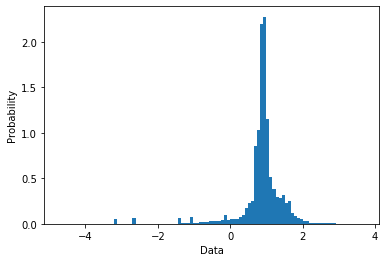

In [45]:
import matplotlib.pyplot as plt
np.random.seed(42)
x = np.random.normal(size=1000)
plt.hist(scores4, density=True, bins=100)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Data');